In [ ]:
from google.cloud import bigquery
import warnings
warnings.filterwarnings('ignore')

# Initialize BigQuery Client
client = bigquery.Client.from_service_account_json("secrets/serviceKey.json")

project_id = "idmpproject-441123"
dataset_id = "uberFareEstimation"
uber_table_id = 'uber_data'
weather_table_id = 'weather_data'

In [ ]:
table_path = f"{project_id}.{dataset_id}.{uber_table_id}"

# Define the query
query = f"""
    SELECT *
    FROM `{table_path}`
"""

# Run the query
query_job = client.query(query)

# Wait for the query to complete and fetch results
results = query_job.result()

uber_df = results.to_dataframe()



table_path = f"{project_id}.{dataset_id}.{weather_table_id}"

# Define the query
query = f"""
    SELECT *
    FROM `{table_path}`
"""

# Run the query
query_job = client.query(query)

# Wait for the query to complete and fetch results
results = query_job.result()

weather_df = results.to_dataframe()

In [ ]:
print(uber_df.shape)
print(weather_df.shape)

In [ ]:
uber_df

In [ ]:
weather_df

In [ ]:
uber_df.rename(columns={"time_stamp": "uber_time_stamp"}, inplace=True)
weather_df.rename(columns={"time_stamp": "weather_time_stamp"}, inplace=True)

In [ ]:
import pandas as pd

# Perform the join
joined_df = pd.merge(
    uber_df,
    weather_df,
    left_on=["uber_time_stamp", "source"],
    right_on=["weather_time_stamp", "location"],
    how="left"  
)

# Replace missing values in 'location' with the values from 'source'
joined_df['location'] = joined_df['location'].fillna(joined_df['source'])

# Ensure the DataFrame is sorted by location and timestamp
joined_df = joined_df.sort_values(by=['location', 'uber_time_stamp'])

# Display the result
joined_df.head(5)


In [ ]:
# Ensure the DataFrame is sorted by location and timestamp
joined_df = joined_df.sort_values(by=['location', 'uber_time_stamp'])

# List of weather columns to fill
weather_columns = ['temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind']

# Create a helper column to track the source timestamp for weather data
joined_df['weather_source_timestamp'] = joined_df['uber_time_stamp']

# Function to fill weather columns and propagate the source timestamp
def fill_weather_and_timestamp(group):
    # Fill weather columns using nearest interpolation
    for col in weather_columns:
        group[col] = group[col].interpolate(method='nearest', limit_direction='both')
    
    # Propagate the source timestamp for missing weather values
    group['weather_source_timestamp'] = group['weather_source_timestamp'].where(
        group[weather_columns].notna().all(axis=1)  # Ensure all weather columns are non-NaN
    ).ffill().bfill()  # Fill forward and backward for timestamps
    
    return group

# Apply the function group-wise
joined_df = joined_df.groupby('location').apply(fill_weather_and_timestamp)

# Check the result
joined_df.head(5)

In [ ]:
# Step 1: Replace 'weather_time_stamp' with 'weather_source_timestamp' where available
joined_df['weather_time_stamp'] = joined_df['weather_source_timestamp'].combine_first(joined_df['weather_time_stamp'])

# Step 2: Remove 'weather_source_timestamp' column
joined_df = joined_df.drop(columns=['weather_source_timestamp'])

# Step 3: Count rows with any null value
rows_before = len(joined_df)
joined_df = joined_df.dropna()  # Remove rows with any null values
rows_after = len(joined_df)

# Step 4: Print the number of rows removed
rows_removed = rows_before - rows_after
print(f"Number of rows removed: {rows_removed}")

In [ ]:
from sklearn.preprocessing import StandardScaler

# Select the weather-related columns and price
weather_columns = ['temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'price']
selected_df = joined_df[weather_columns]

# Separate the weather columns and price
weather_data = selected_df.drop(columns=['price'])
price_data = selected_df['price']

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the weather data
scaled_data = scaler.fit_transform(weather_data)

# Create a DataFrame with the scaled values
scaled_df = pd.DataFrame(scaled_data, columns=weather_data.columns, index=selected_df.index)

# Add the 'price' column back (ensure index is aligned)
scaled_df['price'] = price_data

# Calculate the correlation
correlation_with_price_scaled = scaled_df.corr()['price'].sort_values(ascending=False)

# Print the correlations
print("Correlation with price (scaled weather columns):")
print(correlation_with_price_scaled)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot scatter plots for weather features against price
weather_columns = ['temp', 'clouds', 'humidity', 'pressure', 'rain', 'wind']

for col in weather_columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=joined_df[col], y=joined_df['price'])
    plt.title(f'{col} vs Price')
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.show()

In [15]:
# importing libraries for machine learning

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import KFold, cross_val_score


# change features depending on correlation metrics/what will make model most accurate
features = ['distance', 'cab_type', 'uber_time_stamp', 'destination', 'source', 'surge_multiplier']

# variable that is being predicted
target_variable = 'price'

# Extract X (features) and y (target) from the data
X = joined_df[features]
y = joined_df[target_variable]


In [16]:
# preprocessing for model

# Convert 'time_stamp' into datetime format
X['uber_time_stamp'] = pd.to_datetime(X['uber_time_stamp'])

# Extract useful time-based features
X['hour'] = X['uber_time_stamp'].dt.hour
X['day_of_week'] = X['uber_time_stamp'].dt.dayofweek

# Drop the original 'time_stamp' column as it's no longer needed
X = X.drop('uber_time_stamp', axis=1)


In [23]:
# Configures a ColumnTransformer to preprocess categorical features using OneHotEncoder
# leaves numerical features unchanged for model training


# Define categorical and numerical features
categorical_features = ['cab_type', 'source', 'destination']
numerical_features = ['distance', 'surge_multiplier', 'hour', 'day_of_week']

# Set up the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ]
)

# Display the preprocessor to confirm setup
print(preprocessor)

ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['cab_type', 'source', 'destination']),
                                ('num', 'passthrough',
                                 ['distance', 'surge_multiplier', 'hour',
                                  'day_of_week'])])


In [24]:
# splitting data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# creating pipeline and training the model

# Set up the Random Forest model
rf_model = RandomForestRegressor(n_estimators=150, n_jobs=-1, random_state=42)


# Create a pipeline with preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf_model)
])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

print("Pipeline training complete.")

Pipeline training complete.


In [45]:
# Cross-validation and CV metrics for the RF model using MAE

# Sample 25% of the data for cross-validation
X_sample = X.sample(frac=0.25, random_state=42)
y_sample = y.loc[X_sample.index]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metric (negative MAE)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform cross-validation using the pipeline
cv_scores = cross_val_score(pipeline, X_sample, y_sample, scoring=scorer, cv=kf, n_jobs=-1)

# Convert negative MAE to positive MAE
cv_mae_scores = -cv_scores

# Print the results
print(f"Cross-Validation MAE Scores: {cv_mae_scores}")
print(f"Mean MAE: {np.mean(cv_mae_scores)}")
print(f"Standard Deviation of MAE: {np.std(cv_mae_scores)}")


Cross-Validation MAE Scores: [7.2680678  7.26384357 7.31609203 7.27706038 7.31892279]
Mean MAE: 7.2887973117803755
Standard Deviation of MAE: 0.023844090854827683


In [46]:
# Analyze the target variable's range
y_min = y.min()
y_max = y.max()
y_mean = y.mean()
y_std = y.std()

# Calculate MAE as a percentage of the mean price
mean_mae = np.mean(cv_mae_scores)  # Use the mean MAE from cross-validation

# Print results
print(f"Target Variable (Price) Stats:")
print(f" - Minimum: {y_min}")
print(f" - Maximum: {y_max}")
print(f" - Mean: {y_mean}")
print(f" - Standard Deviation: {y_std}")
print(f" - MAE as Percentage of Mean Price: {mean_mae / y_mean * 100:.2f}%")


Target Variable (Price) Stats:
 - Minimum: 4.5
 - Maximum: 89.5
 - Mean: 15.794429603903785
 - Standard Deviation: 8.557223175263468
 - MAE as Percentage of Mean Price: 46.15%


In [47]:
# Making predictions and evaluating rf model

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 7.117948244287647
Mean Squared Error (MSE): 74.94363231177024
Root Mean Squared Error (RMSE): 8.65699903614239
R² Score: -0.029394493146519096


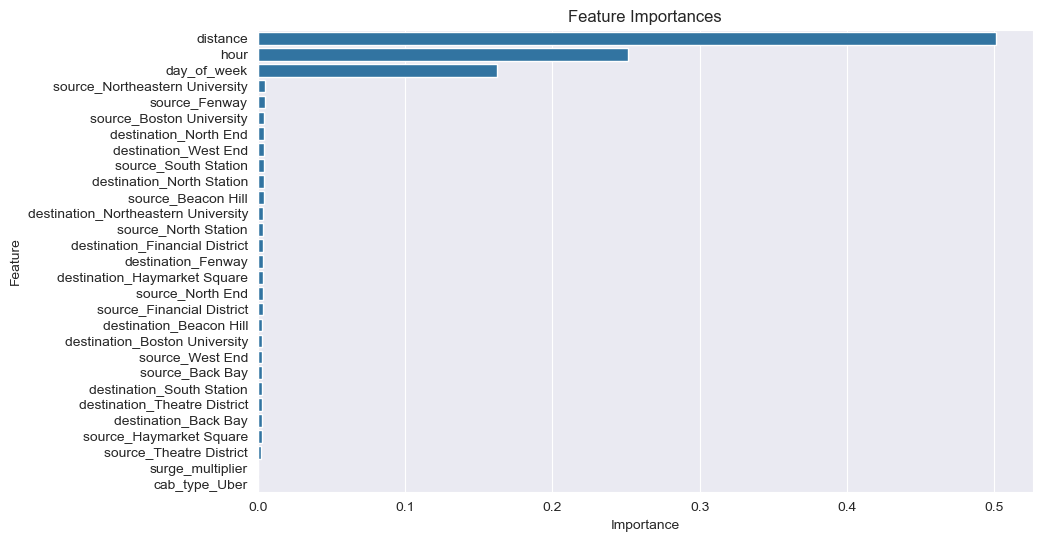

In [72]:
# Access the trained Random Forest model from the pipeline
rf_model_trained = pipeline.named_steps['regressor']

# Get feature importances
feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
all_features = list(feature_names) + numerical_features
feature_importances = rf_model_trained.feature_importances_

# Combine feature names and their importances into a DataFrame
import pandas as pd
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importances")
plt.show()


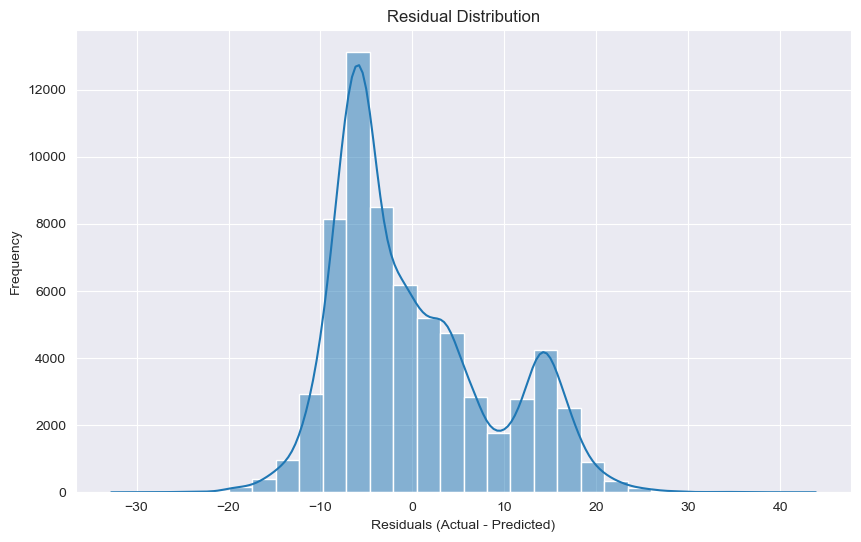

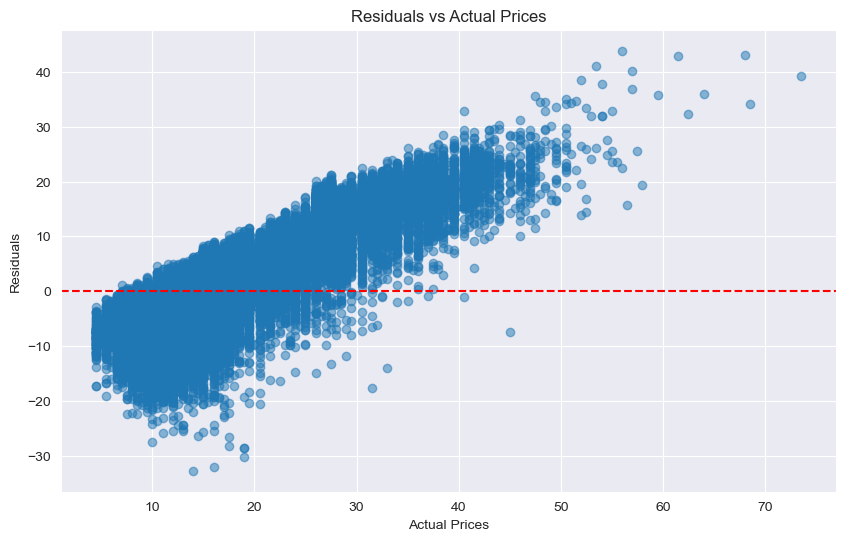

In [50]:
# Analyzing residuals

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred

# Plot residual distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residual Distribution")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

# Scatter plot of residuals vs actual prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals vs Actual Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Residuals")
plt.show()


In [73]:
# Import the XGBoost library
from xgboost import XGBRegressor

# Define the XGBoost model
xgb_model = XGBRegressor(n_estimators=150, learning_rate=0.1, max_depth=6, random_state=42, enable_categorical=True)

# Create a pipeline with preprocessing and the XGBoost model
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Use the same preprocessor as Random Forest
    ('regressor', xgb_model)
])

# Train the pipeline on the training data
pipeline_xgb.fit(X_train, y_train)

print("XGBoost pipeline training complete.")

# Predict on the test set
y_pred_xgb = pipeline_xgb.predict(X_test)


# Evaluate performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print the metrics
print(f"XGBoost Evaluation Metrics:")
print(f" - Mean Absolute Error (MAE): {mae_xgb}")
print(f" - Mean Squared Error (MSE): {mse_xgb}")
print(f" - Root Mean Squared Error (RMSE): {rmse_xgb}")
print(f" - R² Score: {r2_xgb}")



XGBoost pipeline training complete.
XGBoost Evaluation Metrics:
 - Mean Absolute Error (MAE): 6.699471548734518
 - Mean Squared Error (MSE): 64.75618428225293
 - Root Mean Squared Error (RMSE): 8.047122733142134
 - R² Score: 0.11053604634448533


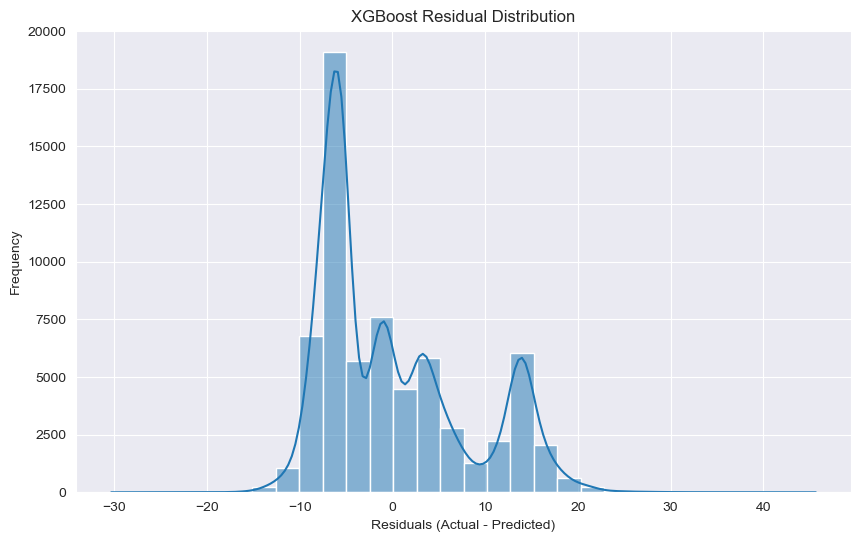

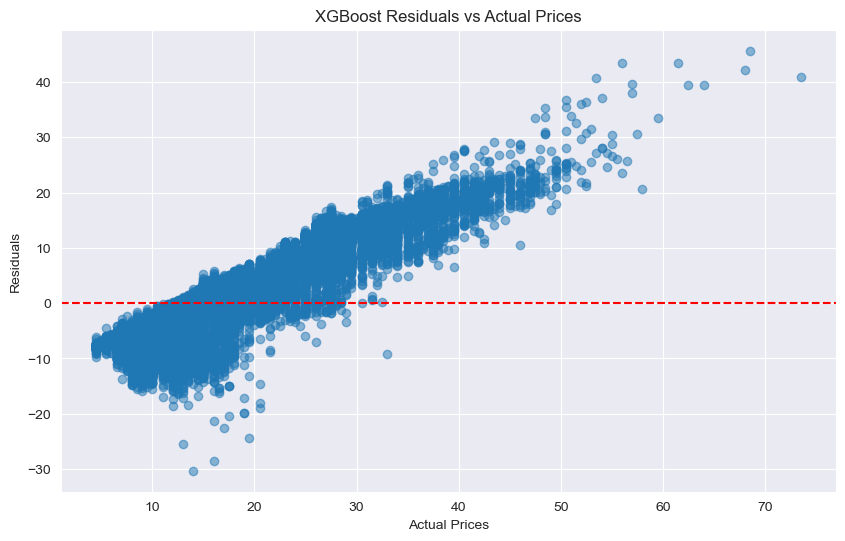

In [70]:
# Analyzing residuals

# Calculate residuals
residuals_xgb = y_test - y_pred_xgb

# Plot residual distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals_xgb, kde=True, bins=30)
plt.title("XGBoost Residual Distribution")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

# Scatter plot of residuals vs actual prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals_xgb, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("XGBoost Residuals vs Actual Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Residuals")
plt.show()

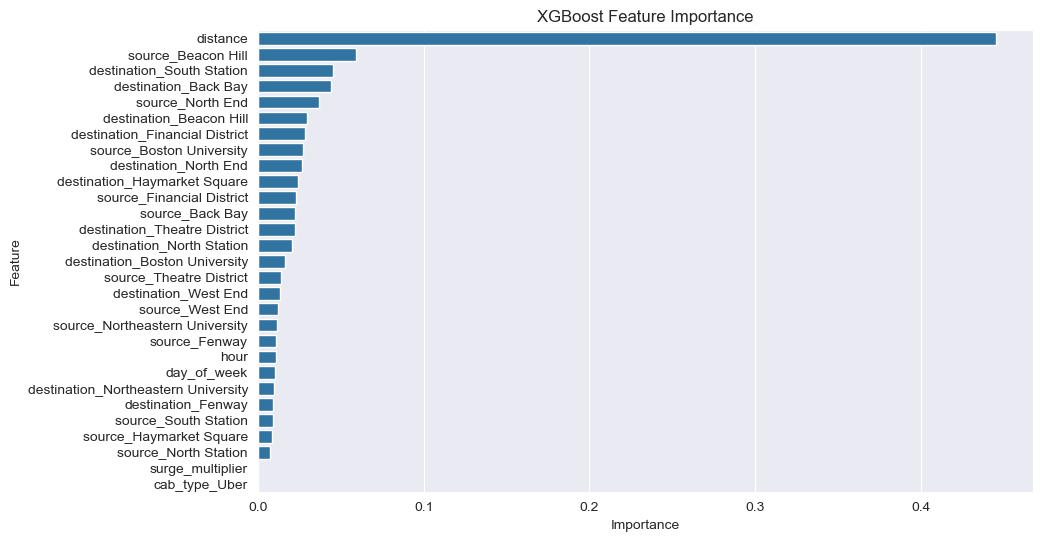

In [74]:
# Get feature importance from the trained XGBoost model
xgb_trained_model = pipeline_xgb.named_steps['regressor']
feature_importance = xgb_trained_model.feature_importances_

# Extract feature names from the preprocessor
feature_names = pipeline_xgb.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
all_features = list(feature_names) + numerical_features

# Combine feature names and their importance into a DataFrame
import pandas as pd
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("XGBoost Feature Importance")
plt.show()
